# Setting IMAGINE to do the fitting

I will use this notebook for testing each of the components needed to set up IMAGINE to fit the model to the SNR data.

In [1]:
import os, sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import imagine as img
# IMAGINE extension package
import imagine_snrs as img_snrs
import shell

## Datasets/Measurements

The first step is including the observational data in IMAGINE. I've added a `datasets` module to the directory `imagine_snrs`, which contains three IMAGINE [dataset](https://imagine-code.readthedocs.io/en/latest/components.html#datasets) classes (for Stokes I, U and Q). These new classes load the fits files, extracting coordinate information and adjust to the internal format. 

This assumes that the following files are available in the present repository:

* data/I_DA530.fits
* data/Q_DA530.fits
* data/U_DA530.fits


Here is an example of how to access one of these dataset objects:

In [2]:
dset = img_snrs.datasets.SNR_DA530_I()
dset.object_id

'SNR G093.3+06.9'

In practice, we would like to load them onto [Measurements](https://imagine-code.readthedocs.io/en/latest/components.html#observables-and-observable-dictionaries) objects (which hold a set of observational datasets).
This is done in the cell below. For convenience, the `Measurements` contain a `show` method, which allows quick inspection:

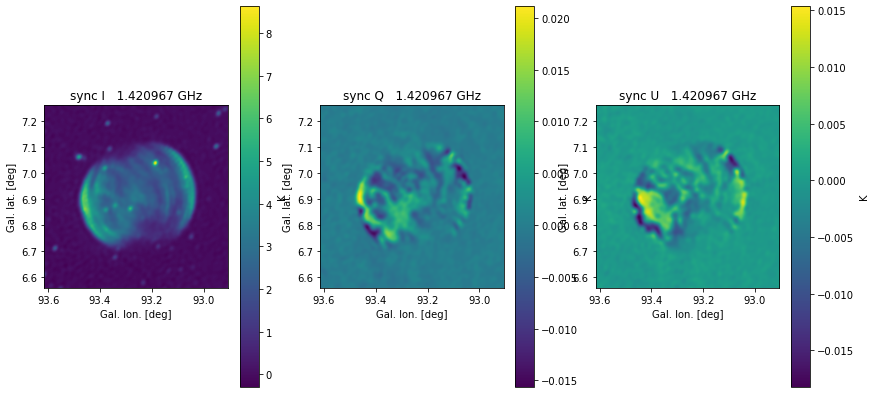

In [3]:
measurements = img.observables.Measurements(img_snrs.datasets.SNR_DA530_I(),
                                            img_snrs.datasets.SNR_DA530_Q(),
                                            img_snrs.datasets.SNR_DA530_U())
plt.figure(figsize=(14,7))
measurements.show()

## Fields

The next step is expressing our models for each of the shell components (magnetic field, thermal electron density, and cosmic ray electron density) as IMAGINE [Fields](https://imagine-code.readthedocs.io/en/latest/components.html#fields) (tutorial [here](https://imagine-code.readthedocs.io/en/latest/tutorial_fields.html)).

For definiteness, let us start by defining a grid:

In [4]:
L = 70*u.pc; N = 150
grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                              box=[[-L,L],[-L,L],[-L,L]], 
                              # Grid resolution
                              resolution=[N, N, N])

### Electron distribution 

Each of the physical components (magnetic field, thermal electron density, cosmic ray electron density) needs to be represented by a different IMAGINE Field object. I have implemented these in the `imagine_snrs.fields` module. The properties of the shell are set up inside the `SupernovaShellThermalElectrons`, and the other components will use the same setup (and depend on `SupernovaShellThermalElectrons` to re-use the same `FieldTransformer` object).

Below, I exemplify/test the `SupernovaShellThermalElectrons` class.

________________________________________________________________________________
[Memory] Calling shell.field_transformer._get_inv_J...
_get_inv_J(<Quantity [[[1., ..., 1.],
            ...,
            [1., ..., 1.]],

           ...,

           [[1., ..., 1.],
            ...,
            [1., ..., 1.]]]>, 
<Quantity [[[-3.875844e-11, ..., -3.875844e-11],
            ...,
            [ 3.875844e-11, ...,  3.875844e-11]],

           ...,

           [[ 3.875844e-11, ...,  3.875844e-11],
            ...,
            [-3.875844e-11, ..., -3.875844e-11]]]>, 
<Quantity [[[-3.875844e-11, ...,  3.875844e-11],
            ...,
            [-3.875844e-11, ...,  3.875844e-11]],

           ...,

           [[ 3.875844e-11, ..., -3.875844e-11],
            ...,
            [ 3.875844e-11, ..., -3.875844e-11]]]>, 
<Quantity [[[-3.875844e-11, ..., -3.875844e-11],
            ...,
            [ 3.875844e-11, ...,  3.875844e-11]],

           ...,

           [[ 3.875844e-11, ...,  3.875844e-11],

../shell/visualization.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_slice.value, **kwargs)


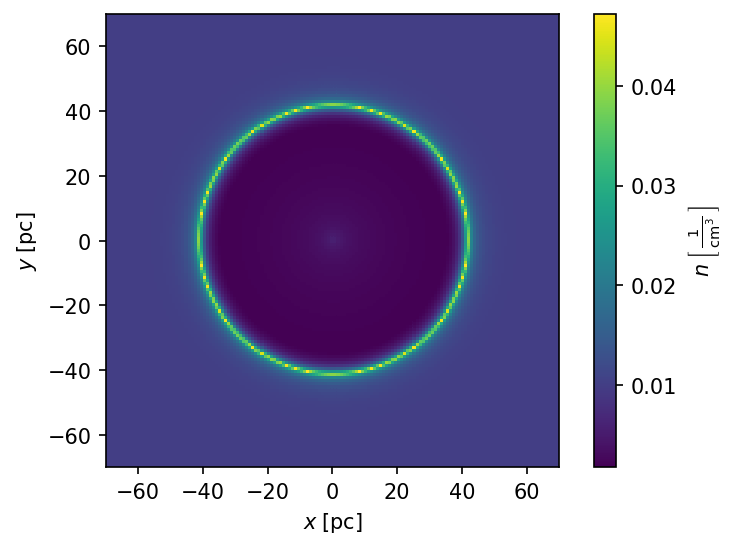

In [5]:
# Parameters dictionary, including shell parameters
parameters = {'initial_electron_density': 0.01*u.cm**-3,
              'shell_V0':0.0153*u.pc/u.yr, 
              'shell_a': 1.3, 
              'shell_b': 10,
              'elapsed_time': 1300*u.yr,
              'shell_radius': 35*u.pc}

# Creates the IMAGINE Field object
ne_field = img_snrs.fields.SNRThermalElectrons(grid, parameters=parameters,
                                               cache_dir=img.rc['temp_dir'])

# Evaluates the field
%time ne_data = ne_field.get_data()

# Plots the result (using previous visualization routine)
shell.visualization.plot_scalar_xy(grid, ne_data);

### Magnetic field

There are two implemented IMAGINE MagneticField subclasses: `SupernovaShellHelicalMagneticField` and `SupernovaShellUniformMagneticField`. They are exemplified below:

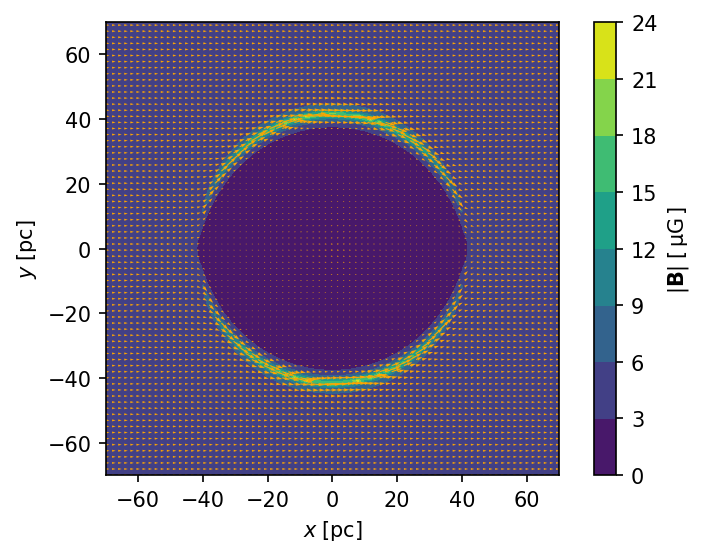

In [6]:
B_uniform = img_snrs.fields.SNRUniformMagneticField(grid,
                                                    parameters={'Bx':4*u.microgauss, 
                                                                'By':0*u.microgauss, 
                                                                'Bz':0*u.microgauss})
b_unif = B_uniform.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_unif_list = [b_unif[:,:,:,i] for i in range(3)]
shell.visualization.plot_vector_xy(grid, b_unif_list, skip=2);

As one can see, the shell properties are inherited from the electron density field.

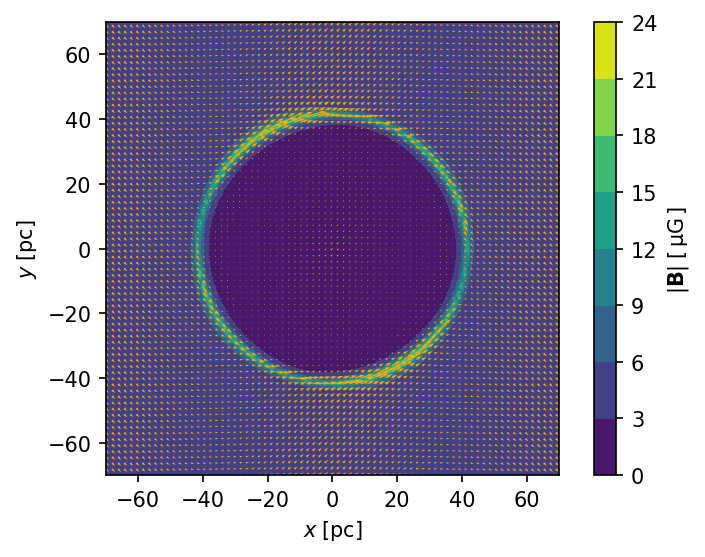

In [7]:
B_helical = img_snrs.fields.SNRHelicalMagneticField(grid,
                                                    parameters={'Bx':4*u.microgauss, 
                                                                'By':0*u.microgauss, 
                                                                'Bz':0*u.microgauss,
                                                                'period': 70*u.pc})
b_hel = B_helical.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_hel_list = [b_hel[...,i] for i in range(3)]
shell.visualization.plot_vector_xy(grid, b_hel_list, skip=2);

### Cosmic ray electrons

Formally, there should be an IMAGINE Field for the cosmic rays. There is, however, still no agreement on what is the adequate generic format for the cosmic ray field base class (due to the requirement of specifying the energy spectrum as well as the spatial distribution). So, we define a provisional base class within the `imagine_snrs` package.

We consider three possibilities of CR electrons, described below.


#### Constant CR

If we assume that the diffusion timescale is much smaller than the other timescales in the problem, the CRe are approximately constant within the box

In [8]:
CR_constant = img_snrs.fields.ConstantCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre': 0.01*u.cm**-3})
ncr_const = CR_constant.get_data()

In [9]:
ncr_const[0,0,0,0]

<Quantity 0.01 1 / cm3>


#### CR in energy equipartition with the magnetic field 

Another simple, but sound assumption

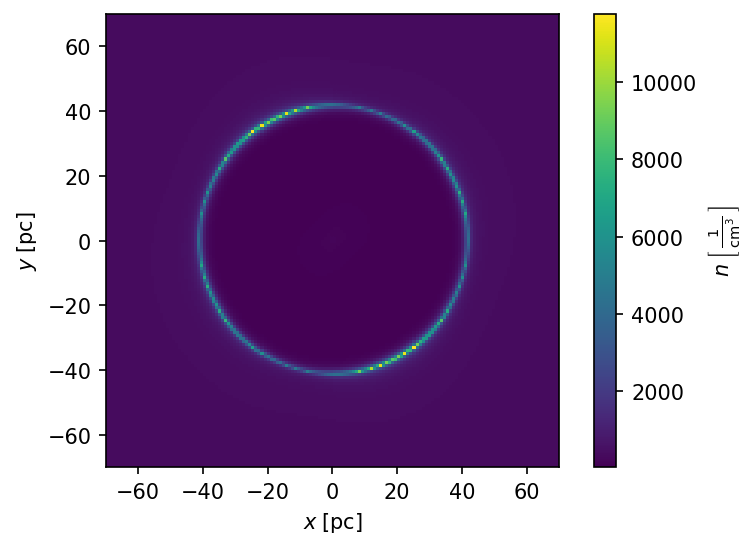

In [10]:
CR_equip = img_snrs.fields.EquipartitionCosmicRayElectrons(grid, 
                                                           parameters={'cr_energy': 1*u.GeV,
                                                                          'Ecr_Em': 1})
ncr_equip = CR_equip.get_data(dependencies={'magnetic_field': b_hel})

shell.visualization.plot_scalar_xy(grid, ncr_equip[...,0]);

#### CRe tracking thermal electorns 

Finally, for completeness, we consider the case where the accelaration process leads to CRe overdensities in the densest parts of the shell. A rough approximation to this is assuming that the CRe density is proportional to the thermal electron density.

In [11]:
CR_tracking = img_snrs.fields.TrackingCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre_nte': 1})
ncr_track = CR_tracking.get_data(dependencies={'thermal_electron_density': ne_data})

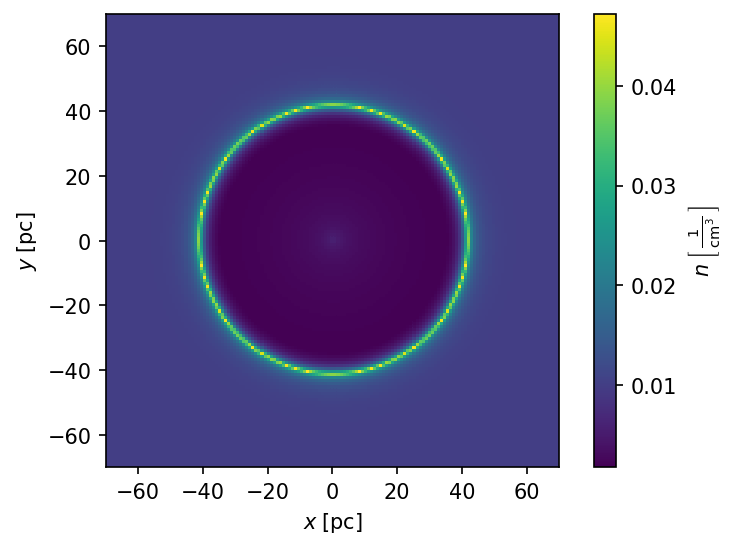

In [12]:
shell.visualization.plot_scalar_xy(grid, ncr_track[...,0]);

## Simulator class

Finally, it is necessary show IMAGINE how to convert the `Fields` into `Observables` using a [Simulator](https://imagine-code.readthedocs.io/en/latest/components.html#simulators) class (tutorial [here](https://imagine-code.readthedocs.io/en/latest/tutorial_simulator.html)).

I have implemented a simple simulator based on the contents of the original `observables` module within the `shell` package. It integrates over the z-direction of the original cartesian grid. The image in the final 2D array is assumed to be centred in the same way as the original image data, and the array obtained from the integration is interpolated/scaled into the same layout as the measured image (accounting for the `distance` which is specified when creating the simulator).

I have included the possibility of specifying a finite beam size using the keyword parameter `beam_kernel_sd`, which should contain the standard deviation associated with the gaussian kernel used in the convolution (in number of pixels).

In [13]:
simulator = img_snrs.simulators.SimpleSynchrotron(measurements, 
                                                  distance=11.3*u.kpc, 
                                                  gamma=3., 
                                                  beam_kernel_sd=3)

In [14]:
simulations = simulator([ne_field, CR_constant, B_helical])

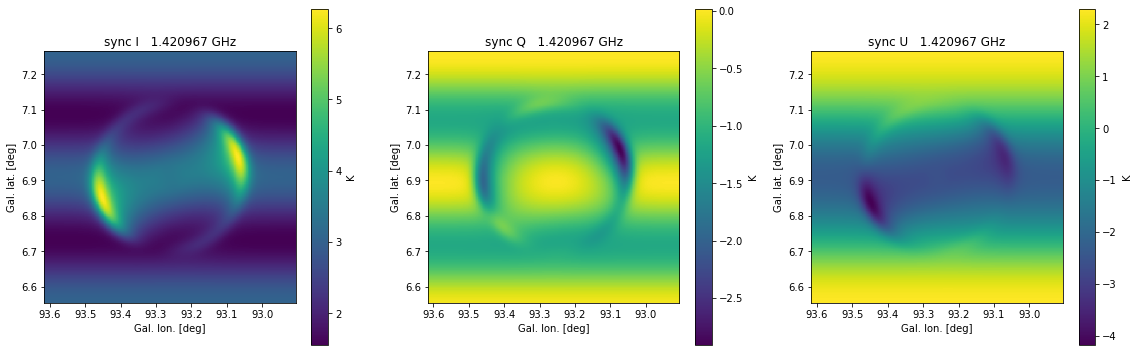

In [15]:
plt.figure(figsize=(16,5))
simulations.show()
plt.tight_layout()

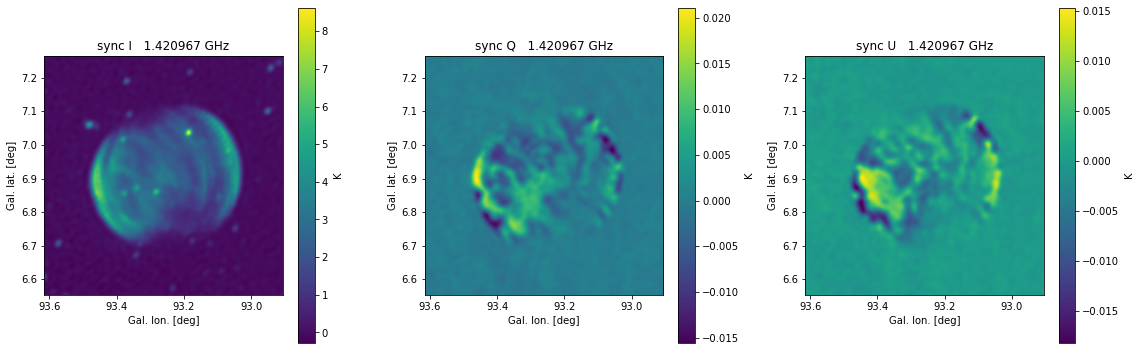

In [16]:
plt.figure(figsize=(16,5))
measurements.show()
plt.tight_layout()

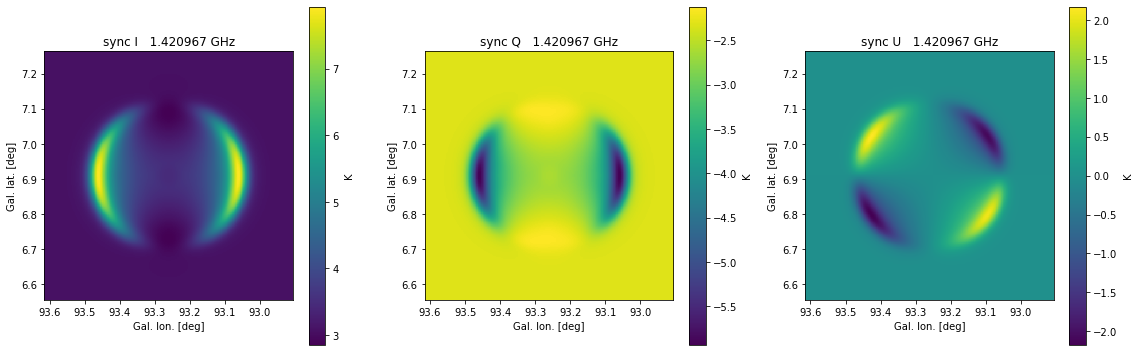

In [17]:
simulations = simulator([ne_field, CR_constant, B_uniform])
plt.figure(figsize=(16,5))
simulations.show()
plt.tight_layout()

## Field factories (and priors)

In the following, I exemplify how to prepare `FieldFactory` objects and specify active/inactive parameters, default values and priors.

In [24]:
from imagine.fields import CustomFieldFactory
from imagine.priors import FlatPrior, GaussianPrior

te_factory = CustomFieldFactory(grid=grid,
                                field_class=img_snrs.fields.SNRThermalElectrons,
                                active_parameters=(),#'initial_electron_density', 'shell_radius'),
                                default_parameters={'initial_electron_density': 0.01*u.cm**-3,
                                                    'shell_V0':0.0153*u.pc/u.yr, 
                                                    'shell_a': 1.3, 
                                                    'shell_b': 10,
                                                    'elapsed_time': 1300*u.yr,
                                                    'shell_radius': 35*u.pc},
                                priors={'initial_electron_density': FlatPrior(1e-4, 10, u.cm**-3),
                                        'shell_V0': FlatPrior(1e-3, 0.1, u.pc/u.yr),
                                        'shell_a': FlatPrior(0.5, 2), 
                                        'shell_b': FlatPrior(1, 50), 
                                        'elapsed_time': FlatPrior(500, 3000, u.yr),
                                        'shell_radius': FlatPrior(10, 200, u.pc)},
                                field_kwargs={'cache_dir': '/run/shm/'})

B_factory  = CustomFieldFactory(grid=grid,
                                field_class=img_snrs.fields.SNRUniformMagneticField,
                                active_parameters =('Bx', 'By', 'Bz'),
                                default_parameters={'Bx':2*u.microgauss, 
                                                   'By':0*u.microgauss, 
                                                   'Bz':0*u.microgauss},
                                 priors={'Bx': FlatPrior(-10, 10, u.microgauss), 
                                         'By': FlatPrior(-10, 10, u.microgauss), 
                                         'Bz': FlatPrior(-10, 10, u.microgauss)})

CR_factory = CustomFieldFactory(grid=grid, 
                                field_class=img_snrs.fields.EquipartitionCosmicRayElectrons,
                                active_parameters=(),#['Ecr_Em'],
                                default_parameters={'cr_energy': 1*u.GeV,
                                                    'Ecr_Em': 1},
                                priors={'Ecr_Em': GaussianPrior(mu=1, sigma=0.1, 
                                                                xmin=1e-2, xmax=10)})

## IMAGINE pipeline

Now we are very close to run this using the IMAGINE pipeline. We first need to initialize the likelihood object. As we are not using stochastic fields, we can use the `SimpleLikelihood` class.

In [25]:
likelihood = img.likelihoods.SimpleLikelihood(measurements)

We have all the ingredients to prepare our pipeline! Some intial tests seem to indicate a possible incompatibility between `numba` and `pyMultiNest`. So, we will instead use the `UltraNest` pipeline (which is slightly slower, but more robust).

In [26]:
pipeline = img.pipelines.UltranestPipeline(run_directory='../runs/test_run',
                                           simulator=simulator, 
                                           factory_list=[B_factory, CR_factory, te_factory],
                                           likelihood=likelihood)

In this initial test, we only try to fit a uniform field, and hopefully get its "best fit" orientation and amplitude. We can inspect *all* active parameters doing:

In [27]:
pipeline.active_parameters

('SNR_unif_magnetic_field_Bx',
 'SNR_unif_magnetic_field_By',
 'SNR_unif_magnetic_field_Bz')

Below a quick test and timing of the complete likelihood function:

In [28]:
%time pipeline._likelihood_function([2,0,0])

CPU times: user 975 ms, sys: 112 ms, total: 1.09 s
Wall time: 1.06 s


-1.3912099940151116e+20

And now we can run and see the results!

DEBUG:ultranest:Testing resume consistency: [-4.24334402e+10 -4.15003733e+10  0.00000000e+00  4.95954083e-01
  4.97803159e-01  4.91615552e-01 -8.09183478e-02 -4.39368202e-02
 -1.67688964e-01]: u=[0.49595408 0.49780316 0.49161555] -> p=[-0.08091835 -0.04393682 -0.16768896] -> L=-41500373317.63147 


[ultranest] PointStore: have 7323 items


INFO:ultranest:PointStore: have 7323 items


[ultranest] Resuming...


INFO:ultranest:Resuming...
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]


[ultranest] constructed region is inconsistent (maxr=0.155764,enlarge=0.000000)3/74173 eff=41.6825% N=400    


[ultranest] Explored until L=-4e+10  0 [-3.971e+10..-3.971e+10]*| it/evals=22565/74947 eff=41.7739% N=400 


INFO:ultranest:Explored until L=-4e+10  


[ultranest] Likelihood function evaluations: 74947


INFO:ultranest:Likelihood function evaluations: 74947


[ultranest] Writing samples and results to disk ...


/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/ultranest/integrator.py:2184: RuntimeWarning: invalid value encountered in double_scalars
  results['logzerr_single'] = (main_iterator.all_H[0] / self.min_num_live_points)**0.5
INFO:ultranest:Writing samples and results to disk ...


[ultranest] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -3.971e+10 +- 0.2612


INFO:ultranest:  logZ = -3.971e+10 +- 0.2612


[ultranest] Effective samples strategy satisfied (ESS = 1869.2, need >500)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1869.2, need >500)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.83, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.83, need <0.5)


[ultranest]   logZ error budget: single: 9.65 bs:0.26 tail:0.01 total:0.26 required:<0.50


INFO:ultranest:  logZ error budget: single: 9.65 bs:0.26 tail:0.01 total:0.26 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



**Posterior report:**

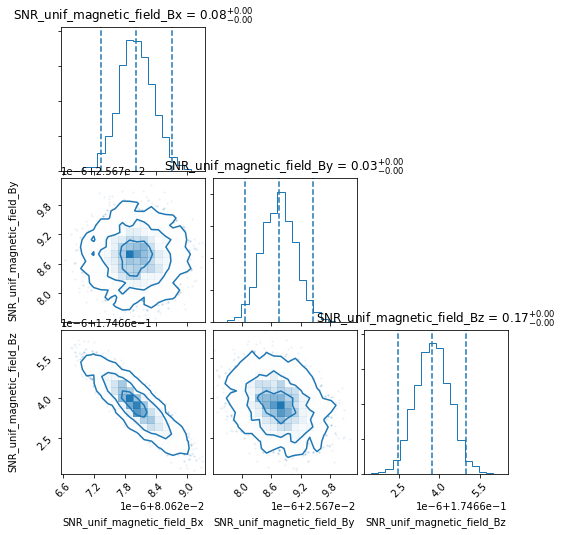

<IPython.core.display.Math object>

**Evidence report:**

<IPython.core.display.Math object>

In [32]:
pipeline();

This took a much longer time than I expected (overnight!), but it finally got there. So, we are good to go, in principle. Below, I plot the median of the median model in the posterior distributions:

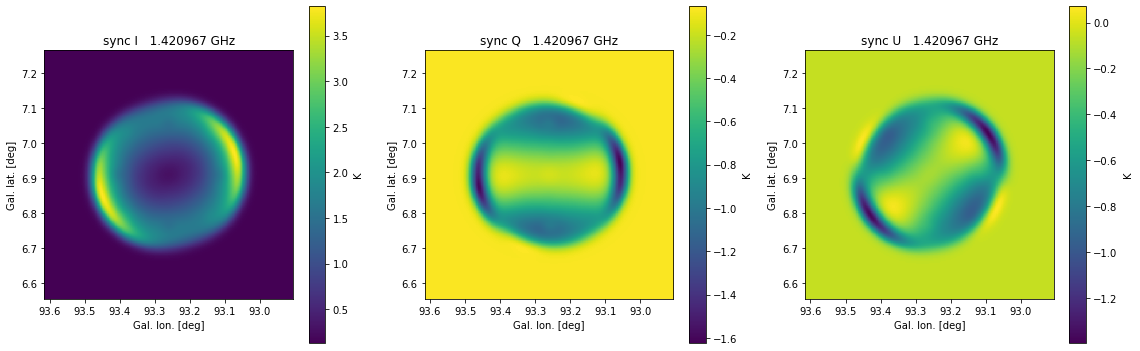

In [36]:
plt.figure(figsize=(16,5))
pipeline.median_simulation.show()
plt.tight_layout()

## Accelerating with PRISM

Running the full nested sampling pipeline still takes a very long time. An atractive alternative is exploring the parameter space with the `PRISM` emulator (using, provisionally, the `lfsr_updates` branch of that repository).

In [ ]:
import imagine_prism as img_prism
from importlib import reload
reload(img_prism)

prism_pipeline = img_prism.PRISMPipeline(pipeline, 
                                         root_dir='..',
                                         working_dir='test_run')

In [ ]:
prism_pipeline.prism_pipe.construct()

In [ ]:
prism_pipeline.prism_pipe.project()